In [ ]:
!pip install requests


In [1]:
import json
import requests

response = requests.get('https://date.nager.at/api/v3/publicholidays/2024/BR')
public_holidays = json.loads(response.content)

for public_holiday in public_holidays:
  print(public_holiday['date'])


2024-01-01
2024-02-12
2024-02-13
2024-03-29
2024-03-31
2024-04-21
2024-05-01
2024-05-30
2024-07-09
2024-09-07
2024-10-12
2024-11-02
2024-11-15
2024-12-25


In [3]:
feriados_br = public_holidays
feriados_br = [feriado['date'] for feriado in feriados_br]

import pandas as pd

feriados_br = pd.DataFrame(feriados_br, columns=['date'])
feriados_br


,date
0,2024-01-01
1,2024-02-12
2,2024-02-13
3,2024-03-29
4,2024-03-31
5,2024-04-21
6,2024-05-01
7,2024-05-30
8,2024-07-09
9,2024-09-07


In [ ]:
#1 quantos feriados há no brasil em todo o ano de 2024?

feriados_br.count()

,0
date,15
month,15
weekday,15


In [10]:
#2 qual mês de 2024 tem o maior número de feriados?

feriados_br['month'] = pd.to_datetime(feriados_br['date']).dt.month
feriados_mes = feriados_br['month'].value_counts()
#criando a coluna mês em extenso: janeiro, fevereiro
feriados_mes.index = ['janeiro', 'fevereiro', 'março', 'abril', 'maio', 'julho', 'setembro', 'outubro', 'novembro', 'dezembro']
#transformando em dataframe
feriados_mes = pd.DataFrame(feriados_mes)
feriados_mes


,count
janeiro,2
fevereiro,2
março,2
abril,2
maio,1
julho,1
setembro,1
outubro,1
novembro,1
dezembro,1


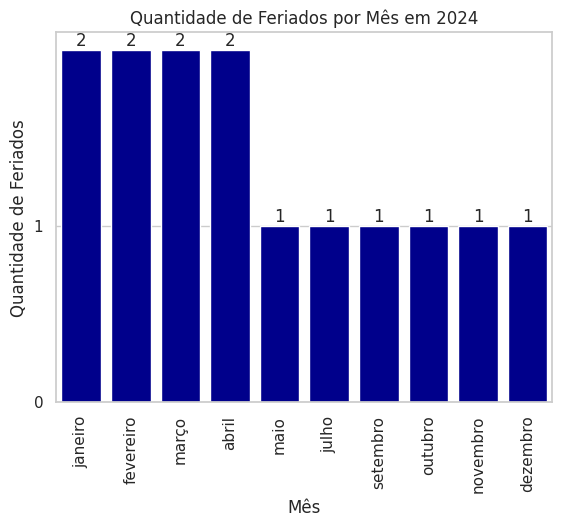

In [27]:
#plotando em seaborn feriados_br

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
ax = sns.barplot(x=feriados_mes.index, y=feriados_mes['count'])
ax.set(xlabel='Mês', ylabel='Quantidade de Feriados')
plt.title('Quantidade de Feriados por Mês em 2024')
plt.xticks(rotation=90)
#y range sem numero decimal
plt.yticks(range(0, 2))
#legenda de y dentro das barras
for i, v in enumerate(feriados_mes['count']):
    ax.text(i, v, str(v), ha='center', va='bottom')
#barras em darkblue
for bar in ax.patches:
    bar.set_facecolor('darkblue')
plt.show()



In [34]:
#3 quanto feriados em 2024 caem em dias da semana (segunda a sexta)?

feriados_br['weekday'] = pd.to_datetime(feriados_br['date']).dt.weekday
dia_semana = feriados_br['weekday'].value_counts()
dia_semana.index = ['sexta', 'domingo', 'segunda', 'quinta', 'sábado','terça','quarta']
dia_semana
#criando a coluna mês em extenso: segunda, terça, quarta, quinta, sexta


,count
sexta,3
domingo,2
segunda,2
quinta,2
sábado,2
terça,2
quarta,1


In [36]:
#plotando em plotly

import plotly.express as px
import plotly.graph_objects as go

fig = px.bar(dia_semana, x=dia_semana.index, y=dia_semana.values)
fig.update_layout(title='Quantidade de Feriados por Dia da Semana em 2024',
                   xaxis_title='Dia da Semana',
                   yaxis_title='Quantidade de Feriados')
#colocando as barras em darkblue
fig.update_traces(marker_color='darkblue')
fig.show()

In [37]:
!pip install openmeteo-requests

In [38]:
!pip install requests-cache retry-requests numpy pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 982.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 2.8 MB/s eta 0:00:00


In [39]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://historical-forecast-api.open-meteo.com/v1/forecast"
params = {
	"latitude": -22.9064,
	"longitude": -43.1822,
	"start_date": "2024-01-01",
	"end_date": "2024-08-01",
	"daily": ["weather_code", "temperature_2m_max", "temperature_2m_min"],
	"timezone": "America/Sao_Paulo"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_weather_code = daily.Variables(0).ValuesAsNumpy()
daily_temperature_2m_max = daily.Variables(1).ValuesAsNumpy()
daily_temperature_2m_min = daily.Variables(2).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}
daily_data["weather_code"] = daily_weather_code
daily_data["temperature_2m_max"] = daily_temperature_2m_max
daily_data["temperature_2m_min"] = daily_temperature_2m_min

daily_dataframe = pd.DataFrame(data = daily_data)
daily_dataframe


Coordinates -22.75°N -43.0°E
Elevation 12.0 m asl
Timezone b'America/Sao_Paulo' b'-03'
Timezone difference to GMT+0 -10800 s


,date,weather_code,temperature_2m_max,temperature_2m_min
0,2024-01-01 03:00:00+00:00,61.0,27.625999,22.925999
1,2024-01-02 03:00:00+00:00,80.0,29.175999,22.976000
2,2024-01-03 03:00:00+00:00,80.0,30.175999,23.476000
3,2024-01-04 03:00:00+00:00,95.0,28.125999,23.825998
4,2024-01-05 03:00:00+00:00,80.0,28.675999,24.476000
...,...,...,...,...
209,2024-07-28 03:00:00+00:00,3.0,33.625999,17.875999
210,2024-07-29 03:00:00+00:00,45.0,27.625999,17.726000
211,2024-07-30 03:00:00+00:00,95.0,23.075998,19.025999
212,2024-07-31 03:00:00+00:00,45.0,24.375999,18.025999


In [81]:
#4 qual foi a temperatura média em cada mês?

#criar coluna para temperatura média diária:
daily_dataframe['temperature_mean'] = (daily_dataframe['temperature_2m_max'] + daily_dataframe['temperature_2m_min']) / 2

#agrupar por mês
daily_dataframe['month'] = daily_dataframe['date'].dt.month
media_mes = daily_dataframe.groupby('month')['temperature_mean'].mean()
#transformar coluna month em extenso
media_mes.index = ['janeiro', 'fevereiro', 'março', 'abril', 'maio', 'junho', 'julho', 'agosto']

media_mes


,temperature_mean
janeiro,27.962290
fevereiro,28.510483
março,27.446966
abril,26.680166
maio,26.109871
junho,23.961832
julho,22.242128
agosto,22.000999


In [53]:
#plotando em plotly

fig = px.bar(media_mes, x=media_mes.index, y=media_mes.values)
fig.update_layout(title='Temperatura Média Mensal',
                   xaxis_title='Mês',
                   yaxis_title='Temperatura Média')
#colocando as barras em laranja escuro se y > 25.00 e laranja se y < 25.00
fig.update_traces(marker_color=media_mes.apply(lambda y: 'orangered' if y > 25.00 else 'orange'))
fig.show()

In [ ]:
#abrindo arquivo json com as weather codes

json.load(open('/content/descriptions.json'))

{'0': {'day': {'description': 'Sunny',
   'image': 'http://openweathermap.org/img/wn/01d@2x.png'},
  'night': {'description': 'Clear',
   'image': 'http://openweathermap.org/img/wn/01n@2x.png'}},
 '1': {'day': {'description': 'Mainly Sunny',
   'image': 'http://openweathermap.org/img/wn/01d@2x.png'},
  'night': {'description': 'Mainly Clear',
   'image': 'http://openweathermap.org/img/wn/01n@2x.png'}},
 '2': {'day': {'description': 'Partly Cloudy',
   'image': 'http://openweathermap.org/img/wn/02d@2x.png'},
  'night': {'description': 'Partly Cloudy',
   'image': 'http://openweathermap.org/img/wn/02n@2x.png'}},
 '3': {'day': {'description': 'Cloudy',
   'image': 'http://openweathermap.org/img/wn/03d@2x.png'},
  'night': {'description': 'Cloudy',
   'image': 'http://openweathermap.org/img/wn/03n@2x.png'}},
 '45': {'day': {'description': 'Foggy',
   'image': 'http://openweathermap.org/img/wn/50d@2x.png'},
  'night': {'description': 'Foggy',
   'image': 'http://openweathermap.org/img/wn/50

In [55]:
#importando para o pandas

import pandas as pd
import json
import pandas.io.json
from pandas import json_normalize


teste = pd.read_json('/content/descriptions.json', orient='index')
teste



,day,night
0,"{'description': 'Sunny', 'image': 'http://open...","{'description': 'Clear', 'image': 'http://open..."
1,"{'description': 'Mainly Sunny', 'image': 'http...","{'description': 'Mainly Clear', 'image': 'http..."
2,"{'description': 'Partly Cloudy', 'image': 'htt...","{'description': 'Partly Cloudy', 'image': 'htt..."
3,"{'description': 'Cloudy', 'image': 'http://ope...","{'description': 'Cloudy', 'image': 'http://ope..."
45,"{'description': 'Foggy', 'image': 'http://open...","{'description': 'Foggy', 'image': 'http://open..."
48,"{'description': 'Rime Fog', 'image': 'http://o...","{'description': 'Rime Fog', 'image': 'http://o..."
51,"{'description': 'Light Drizzle', 'image': 'htt...","{'description': 'Light Drizzle', 'image': 'htt..."
53,"{'description': 'Drizzle', 'image': 'http://op...","{'description': 'Drizzle', 'image': 'http://op..."
55,"{'description': 'Heavy Drizzle', 'image': 'htt...","{'description': 'Heavy Drizzle', 'image': 'htt..."
56,"{'description': 'Light Freezing Drizzle', 'ima...","{'description': 'Light Freezing Drizzle', 'ima..."


In [56]:
#extraindo as informações da coluna day

day_df = json_normalize(teste['day'],
                       sep=',',
                       meta= ['description', 'image'],
                       meta_prefix='d_')

day_df


,description,image
0,Sunny,http://openweathermap.org/img/wn/01d@2x.png
1,Mainly Sunny,http://openweathermap.org/img/wn/01d@2x.png
2,Partly Cloudy,http://openweathermap.org/img/wn/02d@2x.png
3,Cloudy,http://openweathermap.org/img/wn/03d@2x.png
4,Foggy,http://openweathermap.org/img/wn/50d@2x.png
5,Rime Fog,http://openweathermap.org/img/wn/50d@2x.png
6,Light Drizzle,http://openweathermap.org/img/wn/09d@2x.png
7,Drizzle,http://openweathermap.org/img/wn/09d@2x.png
8,Heavy Drizzle,http://openweathermap.org/img/wn/09d@2x.png
9,Light Freezing Drizzle,http://openweathermap.org/img/wn/09d@2x.png


In [57]:
#renomeando o index em coluna weather_codes em teste

teste = teste.rename_axis('weather_codes').reset_index()
teste



,weather_codes,day,night
0,0,"{'description': 'Sunny', 'image': 'http://open...","{'description': 'Clear', 'image': 'http://open..."
1,1,"{'description': 'Mainly Sunny', 'image': 'http...","{'description': 'Mainly Clear', 'image': 'http..."
2,2,"{'description': 'Partly Cloudy', 'image': 'htt...","{'description': 'Partly Cloudy', 'image': 'htt..."
3,3,"{'description': 'Cloudy', 'image': 'http://ope...","{'description': 'Cloudy', 'image': 'http://ope..."
4,45,"{'description': 'Foggy', 'image': 'http://open...","{'description': 'Foggy', 'image': 'http://open..."
5,48,"{'description': 'Rime Fog', 'image': 'http://o...","{'description': 'Rime Fog', 'image': 'http://o..."
6,51,"{'description': 'Light Drizzle', 'image': 'htt...","{'description': 'Light Drizzle', 'image': 'htt..."
7,53,"{'description': 'Drizzle', 'image': 'http://op...","{'description': 'Drizzle', 'image': 'http://op..."
8,55,"{'description': 'Heavy Drizzle', 'image': 'htt...","{'description': 'Heavy Drizzle', 'image': 'htt..."
9,56,"{'description': 'Light Freezing Drizzle', 'ima...","{'description': 'Light Freezing Drizzle', 'ima..."


In [58]:
#drop colunas day e night

teste = teste.drop(columns=['day', 'night'])
teste

,weather_codes
0,0
1,1
2,2
3,3
4,45
5,48
6,51
7,53
8,55
9,56


In [59]:
#unindo teste e day_df pelo índice

teste = teste.join(day_df)
teste

,weather_codes,description,image
0,0,Sunny,http://openweathermap.org/img/wn/01d@2x.png
1,1,Mainly Sunny,http://openweathermap.org/img/wn/01d@2x.png
2,2,Partly Cloudy,http://openweathermap.org/img/wn/02d@2x.png
3,3,Cloudy,http://openweathermap.org/img/wn/03d@2x.png
4,45,Foggy,http://openweathermap.org/img/wn/50d@2x.png
5,48,Rime Fog,http://openweathermap.org/img/wn/50d@2x.png
6,51,Light Drizzle,http://openweathermap.org/img/wn/09d@2x.png
7,53,Drizzle,http://openweathermap.org/img/wn/09d@2x.png
8,55,Heavy Drizzle,http://openweathermap.org/img/wn/09d@2x.png
9,56,Light Freezing Drizzle,http://openweathermap.org/img/wn/09d@2x.png


In [60]:
#tranformando a coluna weather_codes em float

teste['weather_codes'] = teste['weather_codes'].astype(float)

In [61]:
#unindo daily_dataframe com teste em weather_codes = weather_code

daily_dataframe = daily_dataframe.merge(teste, left_on='weather_code', right_on='weather_codes')
daily_dataframe


,date,weather_code,temperature_2m_max,temperature_2m_min,temperature_mean,month,weather_codes,description,image
0,2024-01-01 03:00:00+00:00,61.0,27.625999,22.925999,25.275999,1,61.0,Light Rain,http://openweathermap.org/img/wn/10d@2x.png
1,2024-02-14 03:00:00+00:00,61.0,32.676003,25.175999,28.926001,2,61.0,Light Rain,http://openweathermap.org/img/wn/10d@2x.png
2,2024-03-27 03:00:00+00:00,61.0,25.625999,22.775999,24.201000,3,61.0,Light Rain,http://openweathermap.org/img/wn/10d@2x.png
3,2024-05-27 03:00:00+00:00,61.0,24.825998,20.275999,22.550999,5,61.0,Light Rain,http://openweathermap.org/img/wn/10d@2x.png
4,2024-01-02 03:00:00+00:00,80.0,29.175999,22.976000,26.076000,1,80.0,Light Showers,http://openweathermap.org/img/wn/09d@2x.png
...,...,...,...,...,...,...,...,...,...
209,2024-06-17 03:00:00+00:00,1.0,32.426003,18.325998,25.375999,6,1.0,Mainly Sunny,http://openweathermap.org/img/wn/01d@2x.png
210,2024-06-19 03:00:00+00:00,1.0,31.476000,17.825998,24.650999,6,1.0,Mainly Sunny,http://openweathermap.org/img/wn/01d@2x.png
211,2024-06-24 03:00:00+00:00,1.0,33.426003,21.275999,27.351002,6,1.0,Mainly Sunny,http://openweathermap.org/img/wn/01d@2x.png
212,2024-06-15 03:00:00+00:00,0.0,32.176003,17.775999,24.976002,6,0.0,Sunny,http://openweathermap.org/img/wn/01d@2x.png


In [71]:
#5 Qual foi o weather code predominante em cada mês?

daily_dataframe.groupby('month')['description'].value_counts()
tempo_pred_mes = daily_dataframe.groupby('month')['description'].value_counts()
#montar um dataframe com apenas com o weather code predominante em cada mes
tempo_pred_mes = tempo_pred_mes.unstack().fillna(0)
tempo_pred_mes = tempo_pred_mes.idxmax(axis=1)
#atualizar indice para extenso:
tempo_pred_mes.index = ['janeiro', 'fevereiro', 'março', 'abril', 'maio', 'junho', 'julho', 'agosto']
tempo_pred_mes


,0
janeiro,Light Showers
fevereiro,Light Showers
março,Thunderstorm
abril,Foggy
maio,Partly Cloudy
junho,Foggy
julho,Foggy
agosto,Foggy


In [73]:
#unindo tempo_pred_mes com media_mes em index

tempo_pred_mes = pd.DataFrame(tempo_pred_mes)
tempo_pred_mes1 = tempo_pred_mes.join(media_mes)
#renomeando a coluna 0 para weather
tempo_pred_mes1 = tempo_pred_mes1.rename(columns={0: 'weather'})
tempo_pred_mes1


,weather,temperature_mean
janeiro,Light Showers,27.959999
fevereiro,Light Showers,28.510000
março,Thunderstorm,27.450001
abril,Foggy,26.680000
maio,Partly Cloudy,26.110001
junho,Foggy,23.959999
julho,Foggy,22.240000
agosto,Foggy,22.000000


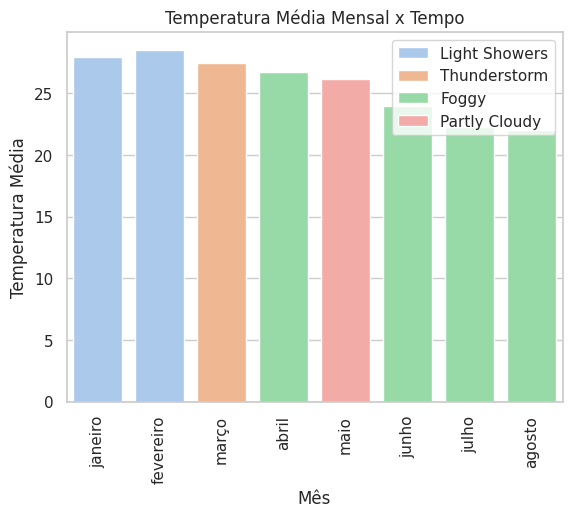

In [85]:
#plotando em seaborn com a coluna weather como hue

sns.barplot(tempo_pred_mes1, x=tempo_pred_mes1.index, y='temperature_mean', hue='weather')
plt.title('Temperatura Média Mensal x Tempo')
plt.xlabel('Mês')
plt.ylabel('Temperatura Média')
plt.xticks(rotation=90)
sns.set_palette("pastel")
sns.set_theme(style="whitegrid")
plt.legend(loc='upper right')
plt.show()

In [86]:
#plotando em plotly

fig = px.bar(tempo_pred_mes1, x=tempo_pred_mes1.index, y='temperature_mean', color='weather')
fig.update_layout(title='Temperatura Média Mensal x Tempo',
                   xaxis_title='Mês',
                   yaxis_title='Temperatura Média')

fig.show()


In [ ]:
feriados_br['date'] = pd.to_datetime(feriados_br['date'])

In [ ]:
#junção da daily_dataframe com feriados_br

#transformar daily_dataframe['date'] em datetime
daily_dataframe['date'] = pd.to_datetime(daily_dataframe['date'])

daily_dataframe1 = daily_dataframe.merge(feriados_br, left_on='date', right_on='date')
daily_dataframe1

,date,weather_code,temperature_2m_max,temperature_2m_min,temperature_mean,month_x,weather_codes,description,image,month_y,weekday
0,2024-01-01,61.0,27.625999,22.925999,25.275999,1,61.0,Light Rain,http://openweathermap.org/img/wn/10d@2x.png,1,0
1,2024-02-12,80.0,37.726002,24.925999,31.326000,2,80.0,Light Showers,http://openweathermap.org/img/wn/09d@2x.png,2,0
2,2024-03-29,95.0,29.575998,23.275999,26.425999,3,95.0,Thunderstorm,http://openweathermap.org/img/wn/11d@2x.png,3,4
3,2024-02-13,3.0,37.926003,25.275999,31.601002,2,3.0,Cloudy,http://openweathermap.org/img/wn/03d@2x.png,2,1
4,2024-05-30,3.0,24.425999,18.675999,21.550999,5,3.0,Cloudy,http://openweathermap.org/img/wn/03d@2x.png,5,3
5,2024-07-09,3.0,23.525999,20.226000,21.875999,7,3.0,Cloudy,http://openweathermap.org/img/wn/03d@2x.png,7,1
6,2024-04-21,45.0,29.726000,19.175999,24.451000,4,45.0,Foggy,http://openweathermap.org/img/wn/50d@2x.png,4,6
7,2024-03-31,2.0,29.175999,23.375999,26.275999,3,2.0,Partly Cloudy,http://openweathermap.org/img/wn/02d@2x.png,3,6
8,2024-05-01,2.0,35.976002,22.625999,29.301001,5,2.0,Partly Cloudy,http://openweathermap.org/img/wn/02d@2x.png,5,2


In [ ]:
#6 qual foi o tempo e a temperatura média em cada feriado de 01/01/2024 a 01/08/2024?

tempo_feriados = daily_dataframe1[['date', 'temperature_mean', 'description']]
tempo_feriados

,date,temperature_mean,description
0,2024-01-01,25.275999,Light Rain
1,2024-02-12,31.326000,Light Showers
2,2024-03-29,26.425999,Thunderstorm
3,2024-02-13,31.601002,Cloudy
4,2024-05-30,21.550999,Cloudy
5,2024-07-09,21.875999,Cloudy
6,2024-04-21,24.451000,Foggy
7,2024-03-31,26.275999,Partly Cloudy
8,2024-05-01,29.301001,Partly Cloudy


In [ ]:
#7 Resposta: apenas os feriados de Páscoa (31/3) e Dia do Trabalhador (01/05) foram aproveitáveis, pois foram parcialmente nublados, possibilitando praia.
#os demais, apesar de apresentarem temperaturas acima de 20 graus, foram de tempo nublado e/ou chuvas e tempestades.

In [ ]:
#8 Resposta: O feriado do dia do Trabalhador foi o mais aproveitável, pois com temperatura amena (29ºC) e com sol.